## Exploratory Data Analysis (EDA)
In this notebook, we perform a comprehensive exploratory data analysis to gain insights into the structure and characteristics of the dataset. Our goal is to identify patterns, detect anomalies, and generate hypotheses that can guide model design and experimentation in later stages. The findings from this analysis will serve as the foundation for designing experiments and developing effective machine learning models.

---

### Dataset Overview: A Focused Look at the DRIAMS-E.coli Sub-dataset

This project utilizes a preprocessed subset of the **DRIAMS dataset** (Database of Resistance against Antimicrobials with MALDI-TOF Mass Spectrometry). The original DRIAMS dataset is a vast collection of over 300,000 bacterial and fungal samples from Switzerland, each with detailed **antimicrobial susceptibility profiles** for 52 different antibiotics. 


### Raw Data Components

The complete DRIAMS dataset includes:

* **MALDI-TOF mass spectra (.txt files):** These are the core data, representing the unique spectral fingerprints of each sample.
* **Metadata:** This accompanies each spectrum and provides crucial information, including microbial species labels and their resistance or sensitivity to various antimicrobials.


### Our Working Sub-dataset: Streamlined for Analysis

Due to the immense size of the original dataset (over 150 GB compressed), we will be using a more manageable, preprocessed version. This simplified dataset, sourced from the **xlopez-ml/DL-AMR** repository, has been filtered to focus on a single species and a limited set of antibiotics for our analysis.

The key features of our working dataset are:

* **Target Species:** We will exclusively use data for ***Staphylococcus aureus*** ($staph$), a common bacterium.
* **Antimicrobials of Interest:** We will focus our analysis on five specific antibiotics:
    * Oxacillin
    * Clindamycin
    * Ceftriaxone
    * Ciprofloxacin
    * Fusidic acid
* **Feature Representation:** The data has been preprocessed, with the raw spectra transformed into a reduced feature set of **6000 bins** per pathogen. This streamlines the analysis and reduces computational complexity.


### Resources

* **Original DRIAMS Dataset:**
    * Dryad: https://datadryad.org/dataset/doi:10.5061/dryad.bzkh1899q
* **Preprocessed Dataset (used in this project):**
    * GitHub: https://github.com/xlopez-ml/DL-AMR/tree/master/datasets
    * Kaggle: https://www.kaggle.com/datasets/drscarlat/driams
---

Import Libraries

In [1]:
%load_ext cuml.accel

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.feature_selection import mutual_info_classif

Read Dataset

In [3]:
df = pd.read_csv('../data/s_aureus_driams_a_bin3_2000_20000Da.csv')
df.head()

2000        2003        2006         2009         2012        2015  \
0  951.428571  826.125000  944.857143   898.428571  1007.714286  936.000000   
1  784.714286  701.125000  681.571429   762.142857   737.571429  733.000000   
2   50.875000   89.142857   56.142857   151.285714   132.714286  110.428571   
3  843.285714  816.500000  734.428571  1027.142857   979.428571  875.571429   
4  307.857143  295.000000  246.714286   181.571429   258.000000  318.714286   

         2018        2021        2024        2027  ...  19991  19994  \
0  828.571429  812.000000  782.714286  741.625000  ...   35.5   20.5   
1  735.857143  659.571429  802.714286  554.375000  ...   30.0   40.5   
2   47.285714   63.428571  100.375000   52.142857  ...    2.5   30.5   
3  912.142857  714.428571  945.428571  886.500000  ...   15.5    8.0   
4  295.714286  300.857143  278.142857  256.125000  ...   25.5   32.0   

       19997                                  code                species  \
0  27.342857  029f0abf-1664-424f-88cb-11c9c8af2b11  Staphylococcus aureus   
1  34.695238  08149af1-10f5-4f02-81d8-3d46d66d4a7a  Staphylococcus aureus   
2  11.288462  08fe3876-ecee-4ddc-9aa9-a84f605757f7  Staphylococcus aureus   
3  20.057143  0a9fdd4b-7180-47c0-849e-cb32d46da94c  Staphylococcus aureus   
4  24.990476  0d82f4c4-473c-49d8-8c85-e3e36e96d047  Staphylococcus aureus   

   Oxacillin  Clindamycin  Ceftriaxone  Ciprofloxacin  Fusidic acid  
0        0.0          0.0          0.0            0.0           1.0  
1        0.0          0.0          0.0            0.0           0.0  
2        0.0          0.0          0.0            0.0           0.0  
3        0.0          0.0          0.0            0.0           0.0  
4        1.0          0.0          1.0            1.0           0.0  

[5 rows x 6007 columns]

All avalibale antibiotic for s_aureus

In [4]:
antibiotics = df.columns[-5:].to_list()
antibiotics

['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid']

#### Dataset overview

In [5]:
summary_data = []

for col in antibiotics:
    all_data = df[col].count()
    positive = (df[col] == 1).sum()
    negative = (df[col] == 0).sum()
    summary_data.append({
        'Antibiotic': col,
        'Number of Samples': all_data,
        'Resistant': positive,
        'Susceptible': negative
    })

summary_data = pd.DataFrame(summary_data)
summary_data

Antibiotic  Number of Samples  Resistant  Susceptible
0      Oxacillin               3790        726         3064
1    Clindamycin               3575        519         3056
2    Ceftriaxone               3640        712         2928
3  Ciprofloxacin               3757        616         3141
4   Fusidic acid               3766        253         3513

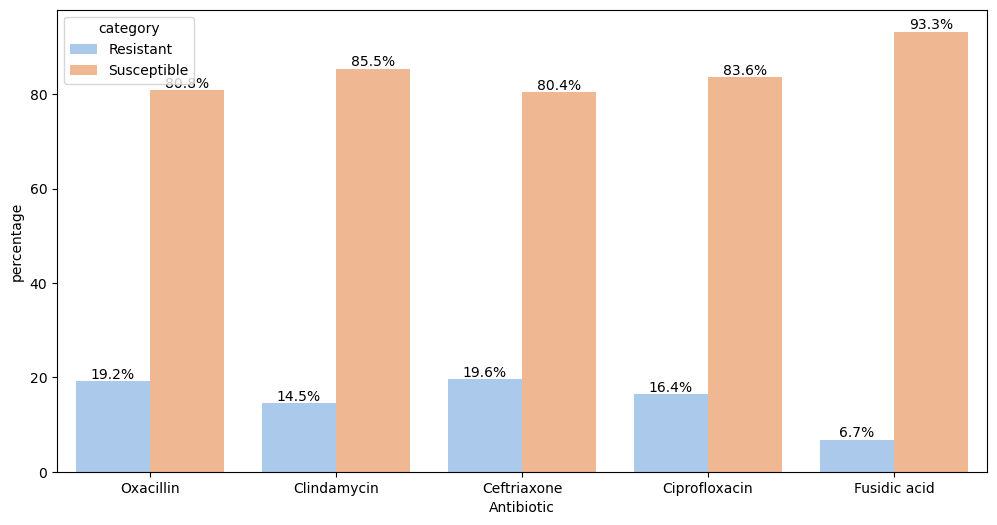

In [6]:
summary_data['Resistant_percentage'] = (summary_data['Resistant'] / summary_data['Number of Samples']) * 100
summary_data['Susceptible_percentage'] = (summary_data['Susceptible'] / summary_data['Number of Samples']) * 100

melted_df = summary_data.melt(
    id_vars=['Antibiotic'],
    value_vars=['Resistant_percentage', 'Susceptible_percentage'],
    var_name='category',
    value_name='percentage'
)

melted_df['category'] = melted_df['category'].replace({
    'Resistant_percentage': 'Resistant',
    'Susceptible_percentage': 'Susceptible'
})

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=melted_df,
    x='Antibiotic',
    y='percentage',
    hue='category',
    palette='pastel'
    
)
plt.rcParams['legend.fontsize'] = 12

for p in ax.patches:
    if p.get_height():
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

Correlation between Antobiotics

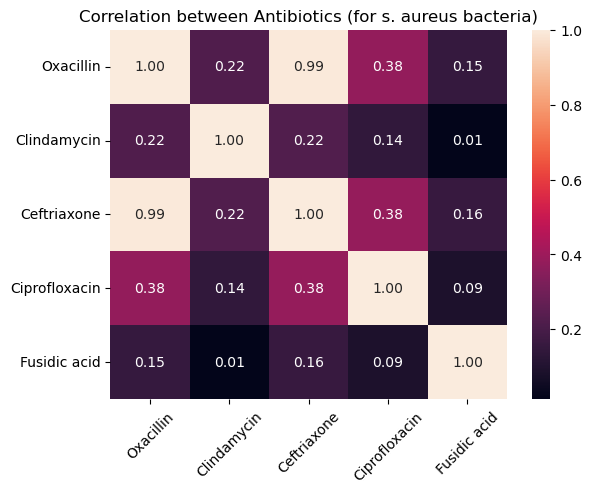

In [7]:
labels = df.iloc[:, -5:].dropna()
sns.heatmap(labels.corr(), annot=True, fmt='.2f')
plt.title('Correlation between Antibiotics (for s. aureus bacteria)')
plt.xticks(rotation=45)
plt.show()

#### Mass Spectrum Data

In [8]:
def plot_mass_spectra_overlay(mass_spectrums, title="Mass Spectra Overlay",
                            labels = None, colors = None, xlim = (2000, 20000), xtick_step = 500):

    plt.figure(figsize=(12, 6))

    def prepare_data(mass_spectrum):
        mz, intensity = mass_spectrum.index.to_numpy(dtype=int), mass_spectrum.to_numpy()
        mask = (mz >= xlim[0]) & (mz <= xlim[1])
        return mz[mask], intensity[mask]

    if labels is None:
        labels = [f"Spectrum {i+1}" for i in range(len(mass_spectrums))]

    for i, mass_spectrum in enumerate(mass_spectrums):
        mz, intensity = prepare_data(mass_spectrum)
        
        plot_kwargs = {'lw': 1, 'label': labels[i], 'alpha': 0.5}
        if colors and i < len(colors):
            plot_kwargs['color'] = colors[i]
        
        plt.plot(mz, intensity, **plot_kwargs)

    plt.title(title)
    plt.xlabel("m/z (mass-to-charge ratio)")
    plt.ylabel("Intensity")
    plt.xlim(xlim)
    plt.xticks(np.arange(xlim[0], xlim[1] + 1, xtick_step), rotation=50)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Sample MS Visualization

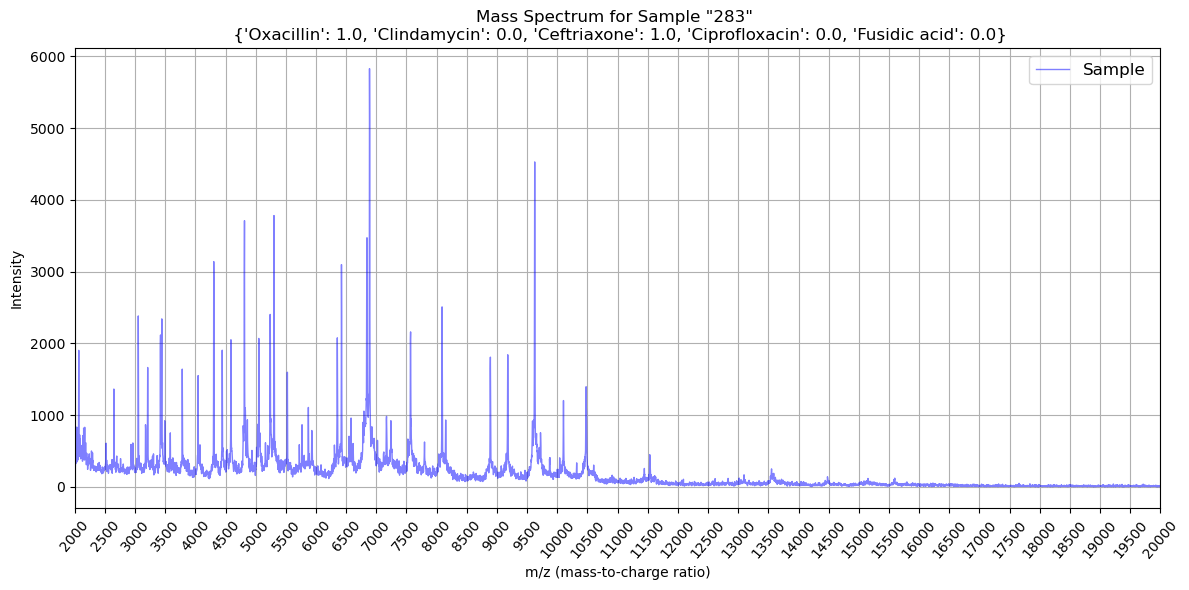

In [9]:
random_sample_index = random.randint(0, len(df))
sample = df.iloc[random_sample_index, :]
labels = sample[-5:]
mass_spectrum = sample[:-7]

plot_mass_spectra_overlay(
    [mass_spectrum], 
    title=f'Mass Spectrum for Sample "{random_sample_index}" \n {labels.to_dict()}', 
    labels=["Sample"],
    colors=['blue']
)

Mean MS for each Antibiotics

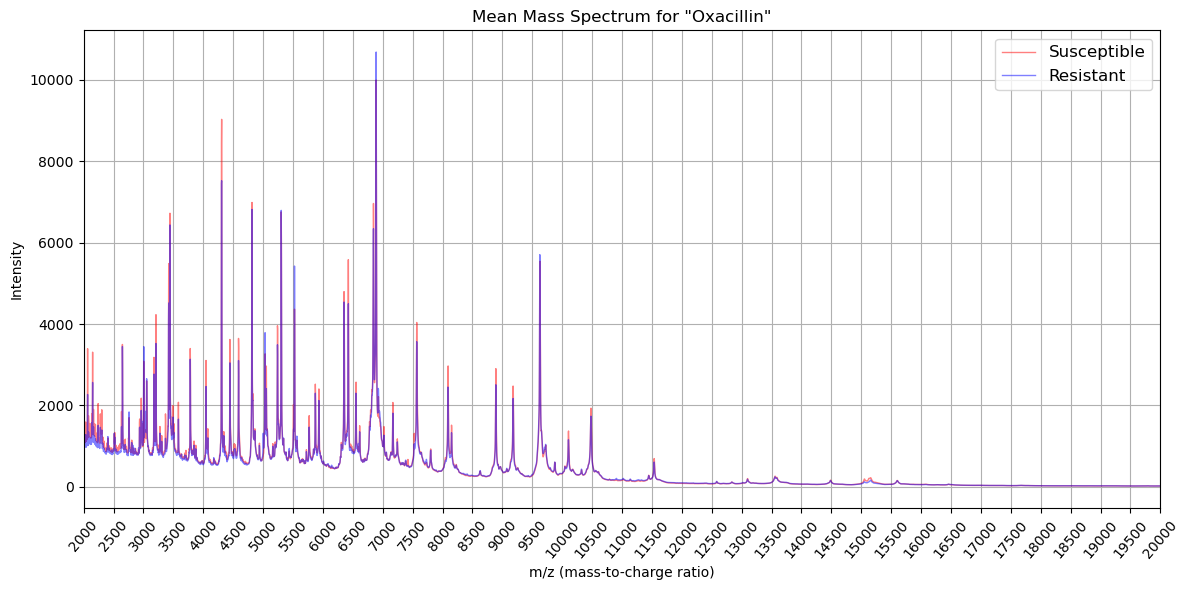

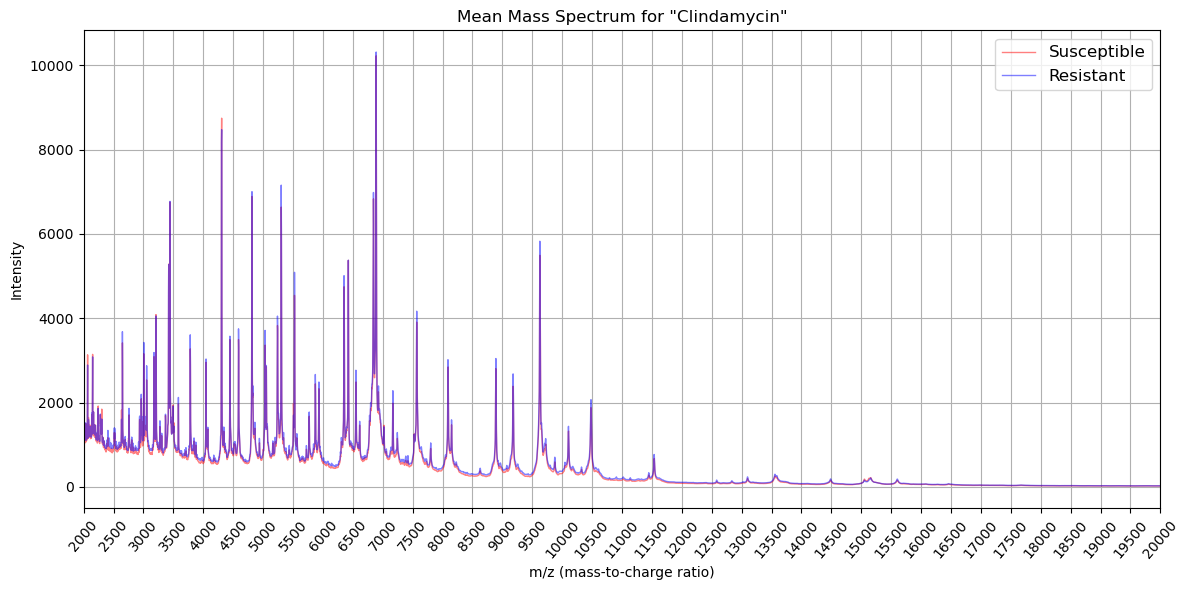

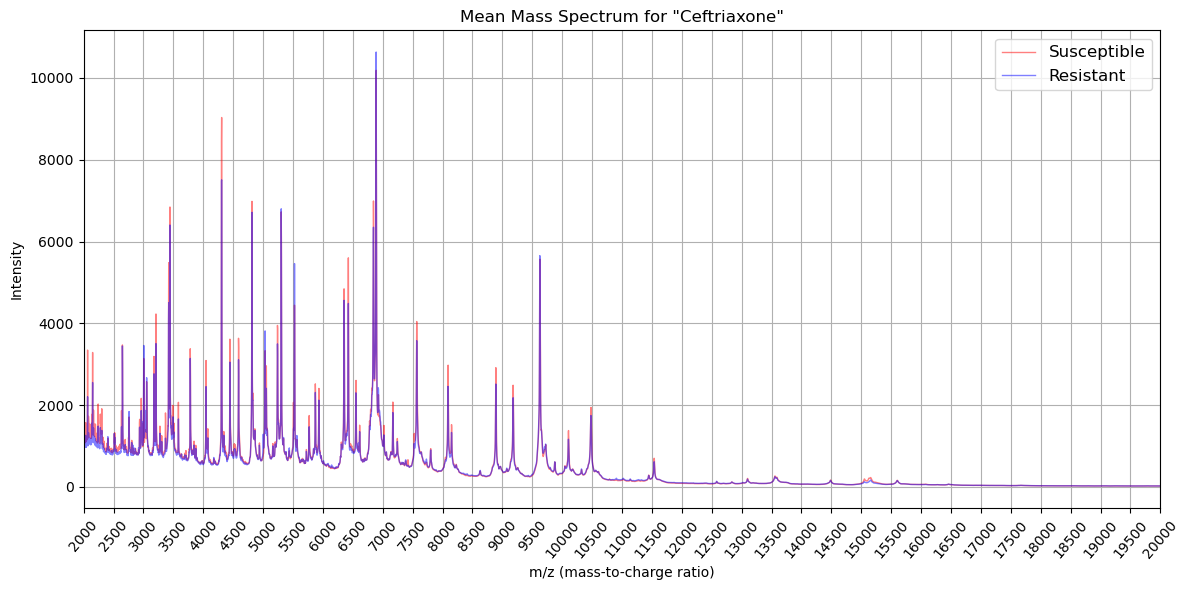

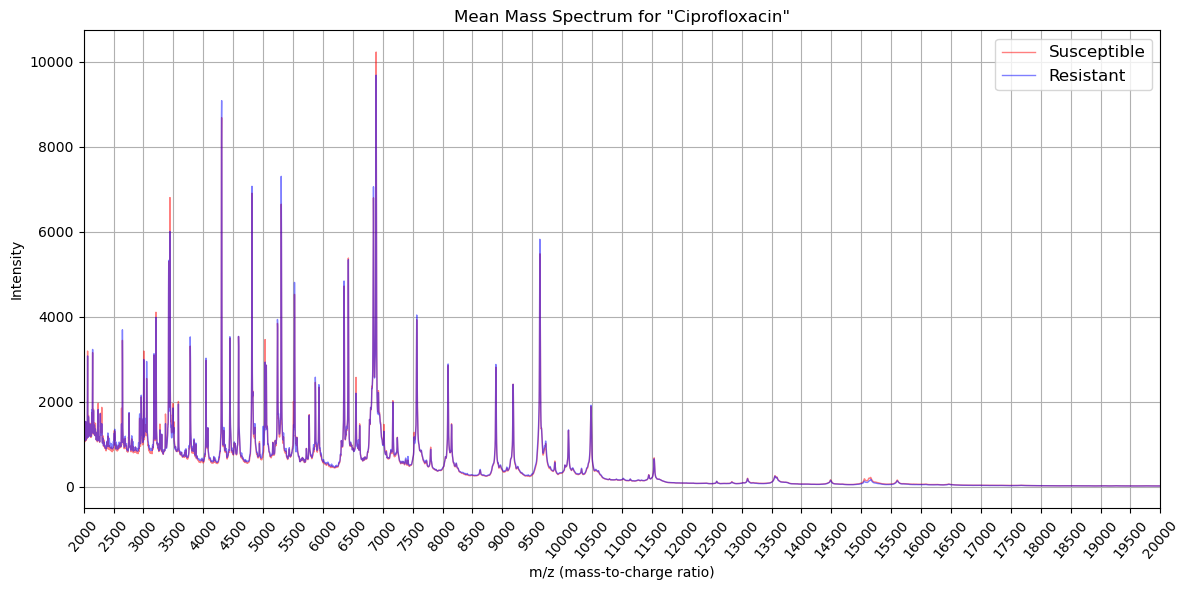

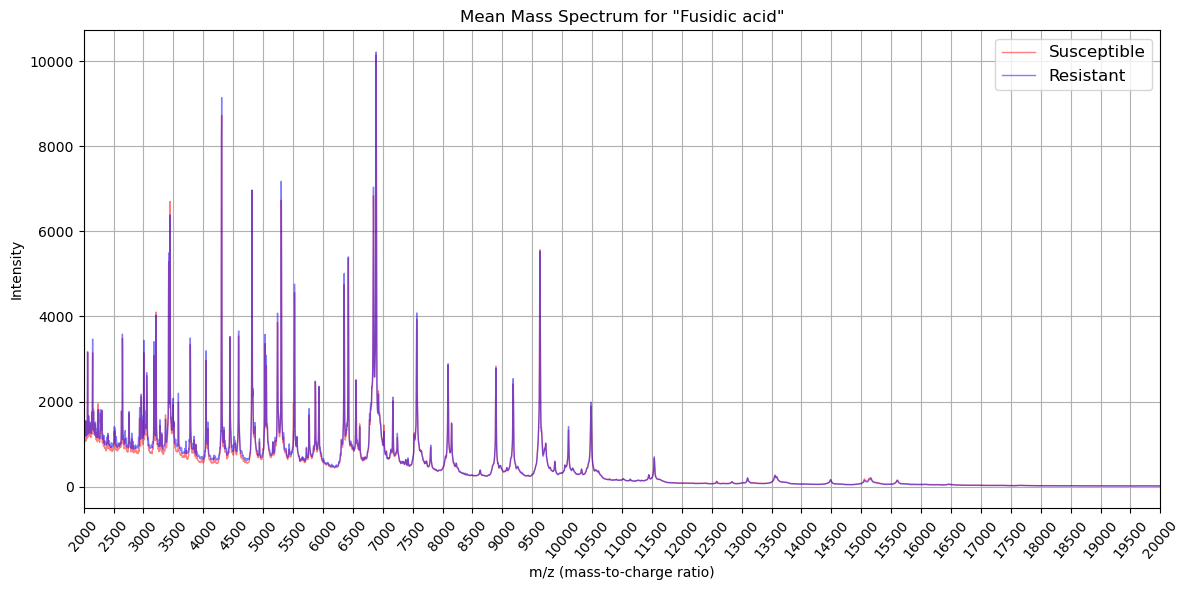

In [10]:
for antibiotic in antibiotics:
    resistant = df.loc[df[antibiotic] == 1, :].iloc[:, :-7].mean()
    susceptible = df.loc[df[antibiotic] == 0, :].iloc[:, :-7].mean()

    plot_mass_spectra_overlay(
    [susceptible, resistant], 
    title=f'Mean Mass Spectrum for "{antibiotic}"', 
    labels=["Susceptible", "Resistant"],
    colors=['red', 'blue']
)


Variance MS for each Antibiotics

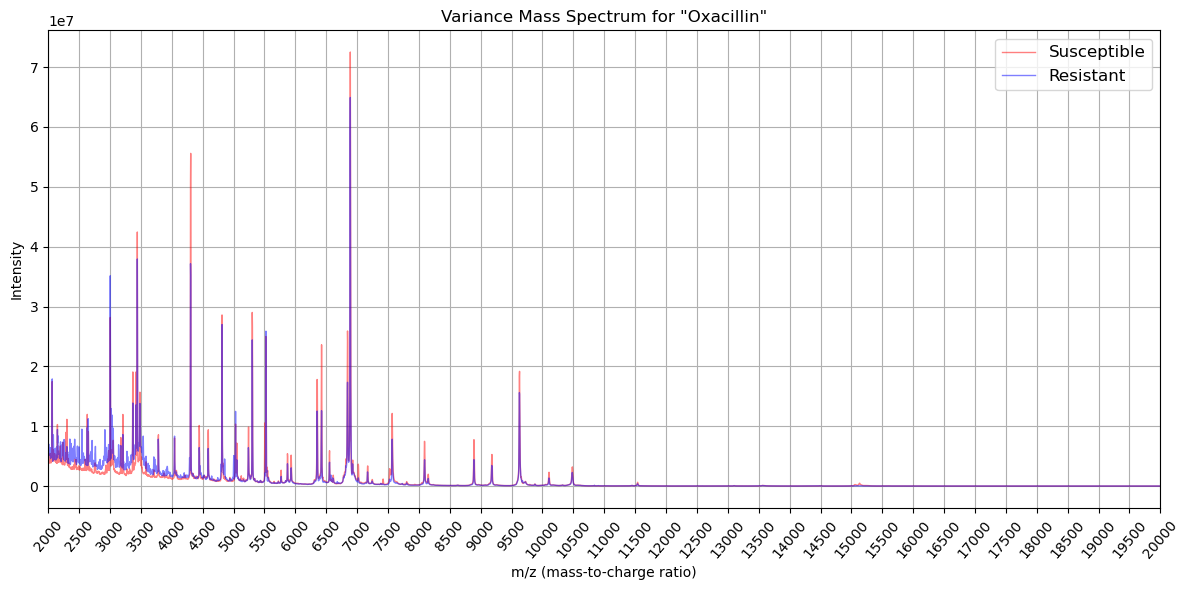

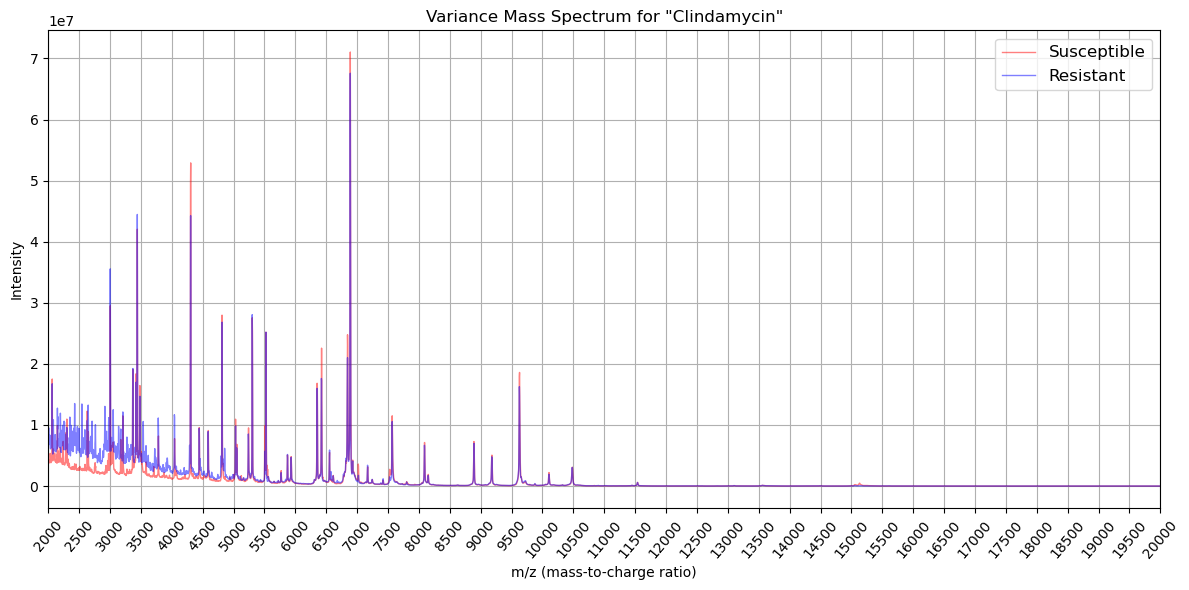

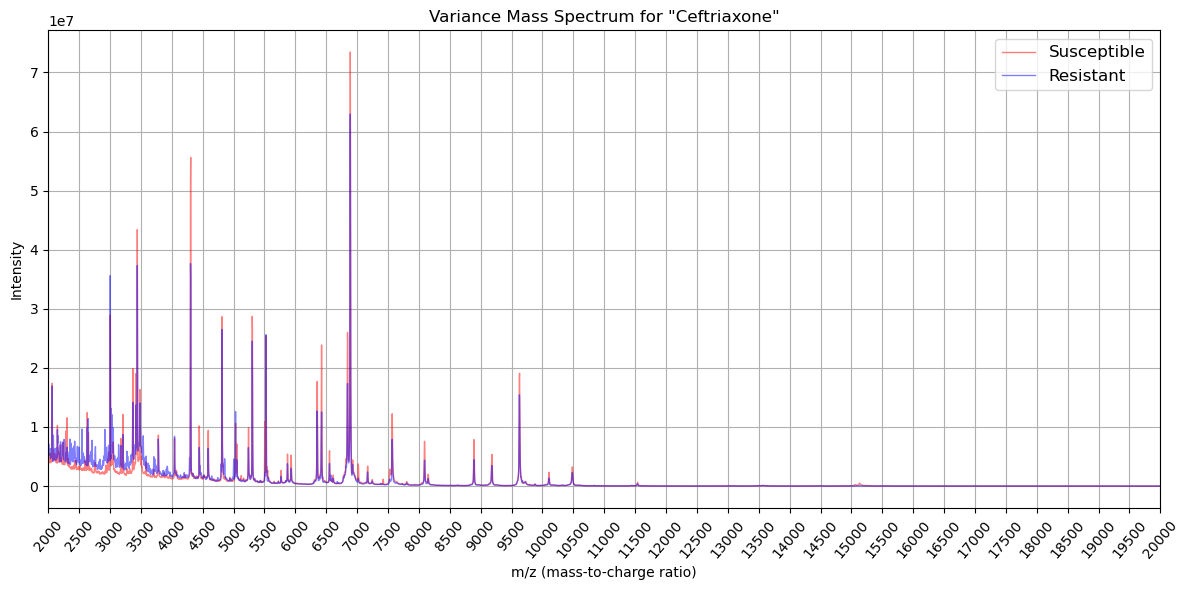

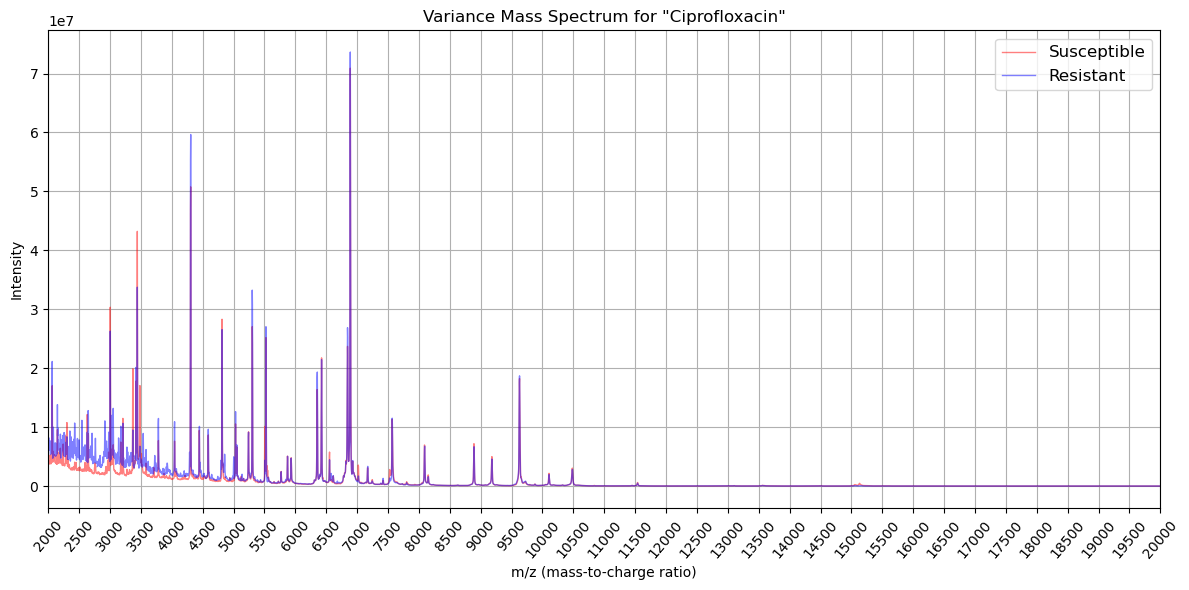

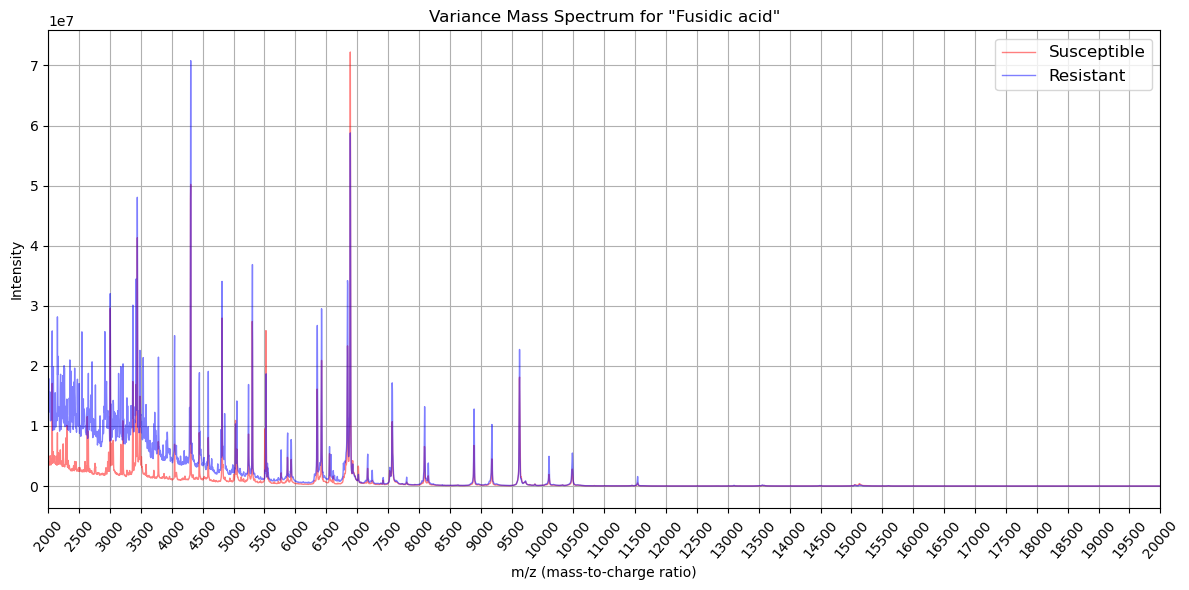

In [11]:
for antibiotic in antibiotics:
    resistant = df.loc[df[antibiotic] == 1, :].iloc[:, :-7].var()
    susceptible = df.loc[df[antibiotic] == 0, :].iloc[:, :-7].var()

    plot_mass_spectra_overlay(
    [susceptible, resistant], 
    title=f'Variance Mass Spectrum for "{antibiotic}"', 
    labels=["Susceptible", "Resistant"],
    colors=['red', 'blue']
)


### Dimensionality Reduction

In [12]:
def plot_dimensionality_reduction(df, n_features=6000, title='Dimensionality Reduction Techniques'):

    X = df.iloc[:, :n_features]
    y = df.iloc[:, n_features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # t-SNE (Note: This can be slow for large datasets)
    tsne = TSNE(n_components=2, perplexity=30)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # UMAP
    reducer = umap.UMAP(n_components=2)
    X_umap = reducer.fit_transform(X_scaled)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    # PCA Plot
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
    ax1.set_title('PCA Visualization')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.grid(True)
    
    # t-SNE Plot
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
    ax2.set_title('t-SNE Visualization')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.grid(True)

    # UMAP Plot
    scatter3 = ax3.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis', alpha=0.7)
    ax3.set_title('UMAP Visualization')
    ax3.set_xlabel('UMAP Component 1')
    ax3.set_ylabel('UMAP Component 2')
    ax3.grid(True)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

[2025-09-03 18:57:17.948] [CUML] [info] Building knn graph using brute force (configured from build_algo='auto')


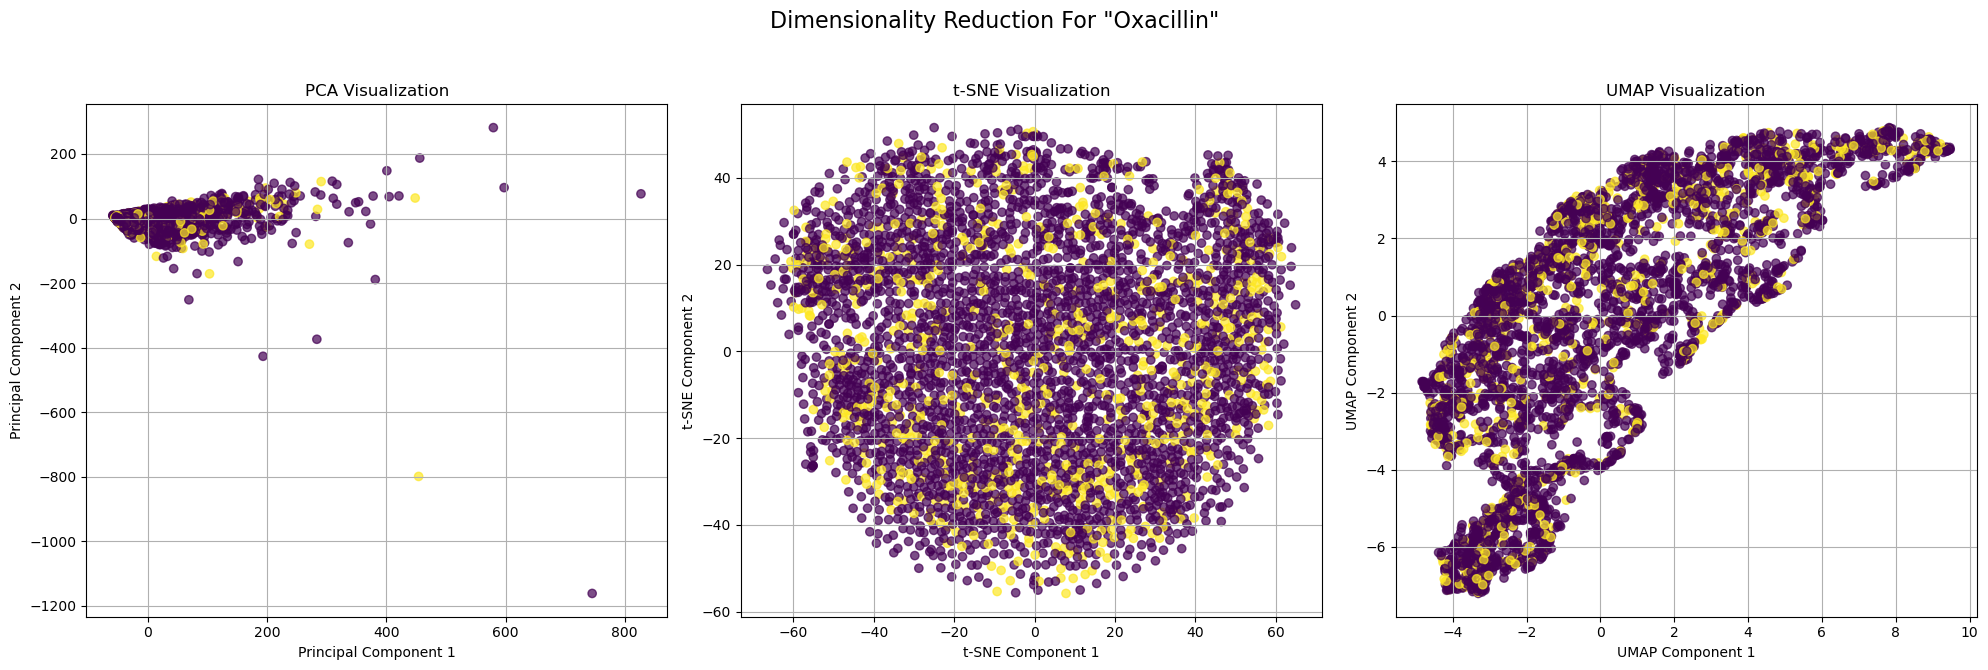

[2025-09-03 18:57:49.138] [CUML] [info] Building knn graph using brute force (configured from build_algo='auto')


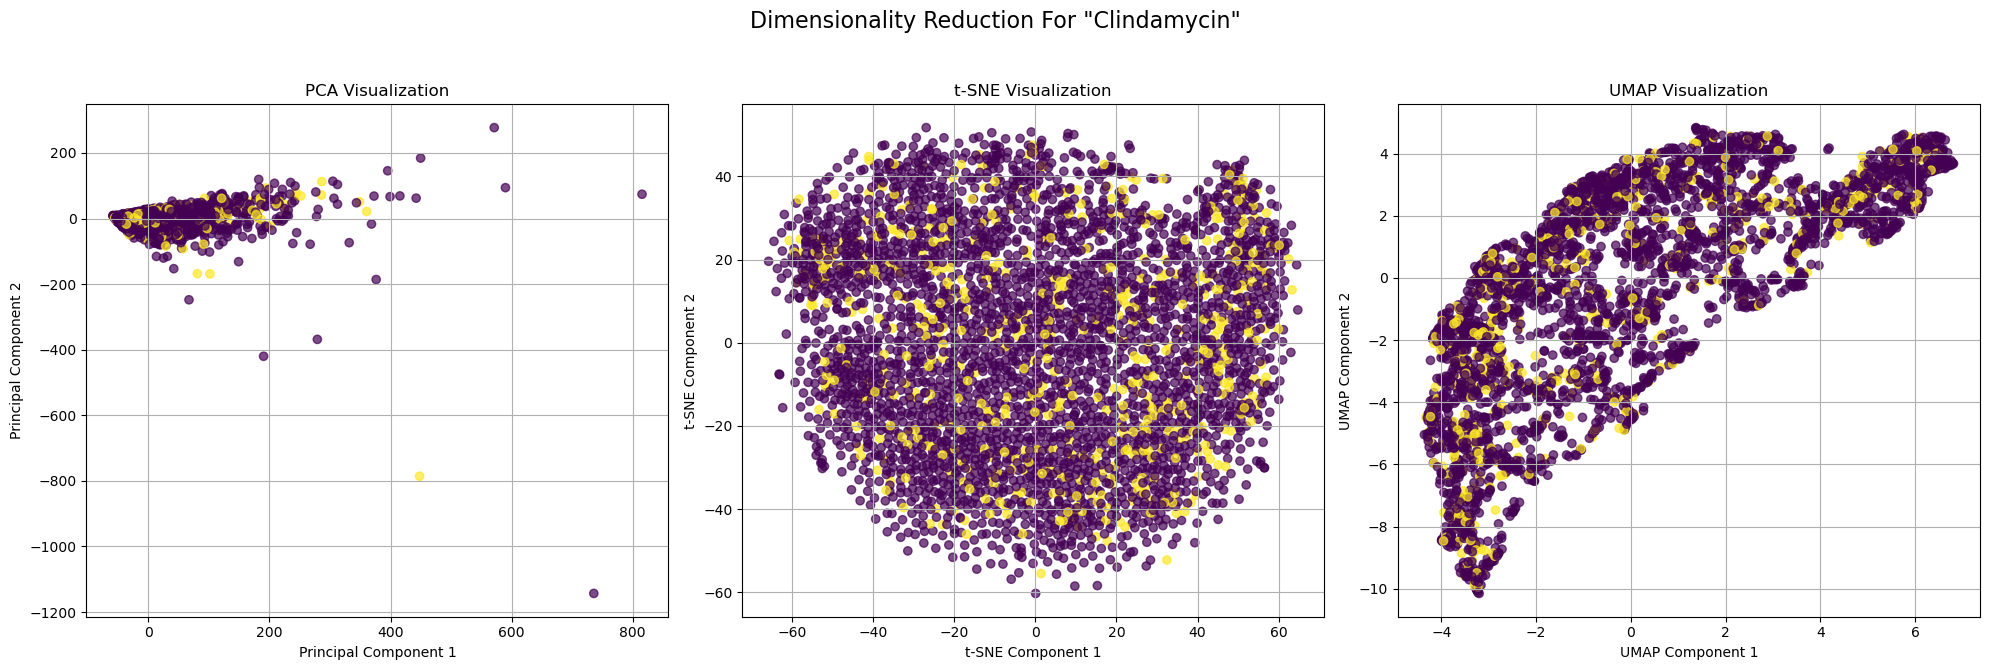

[2025-09-03 18:58:19.421] [CUML] [info] Building knn graph using brute force (configured from build_algo='auto')


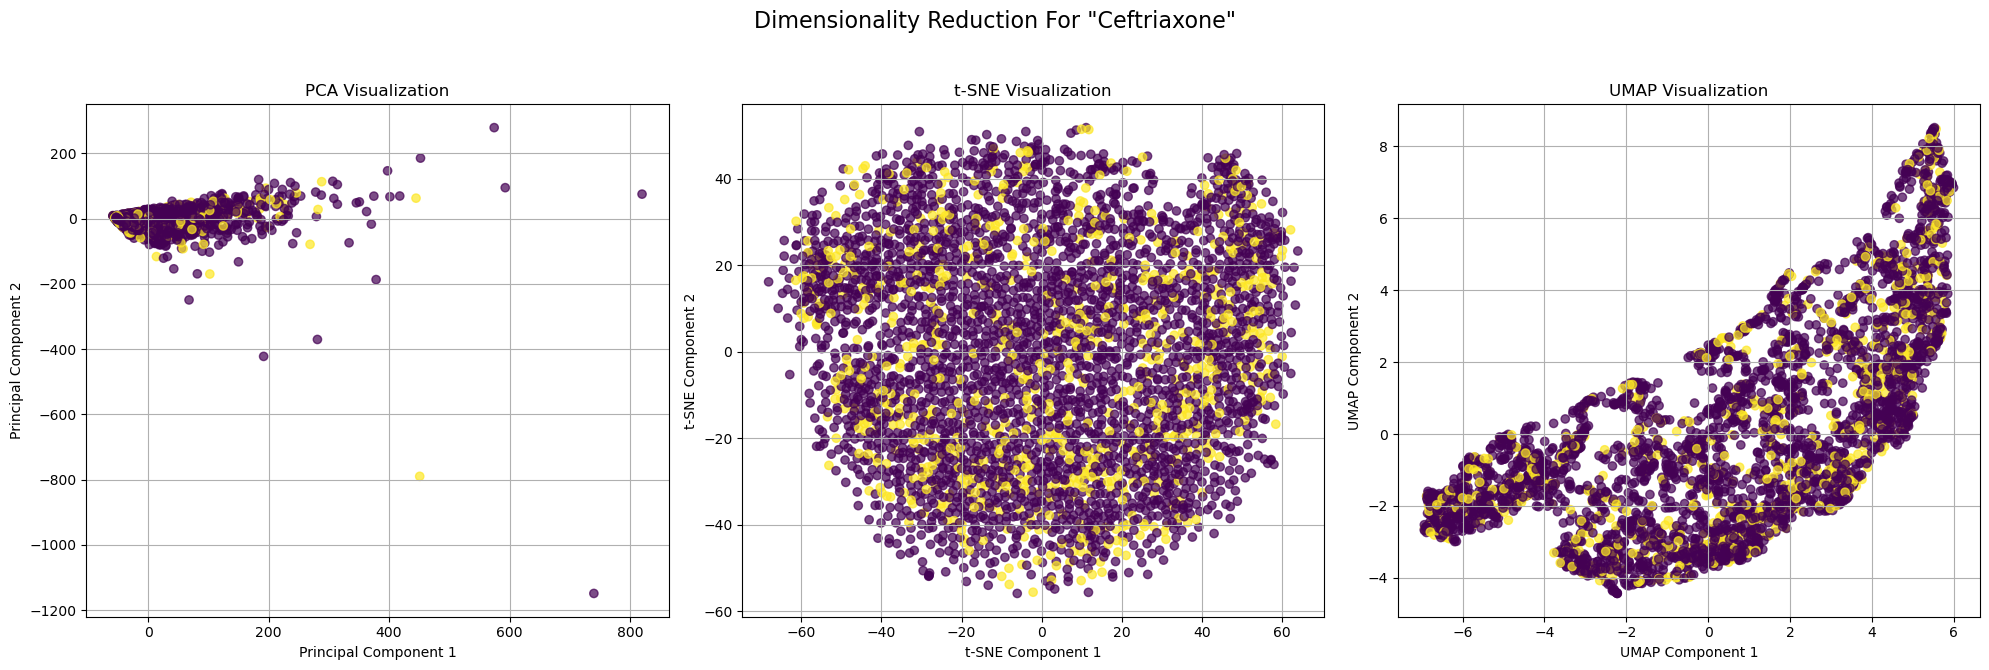

[2025-09-03 18:58:50.380] [CUML] [info] Building knn graph using brute force (configured from build_algo='auto')


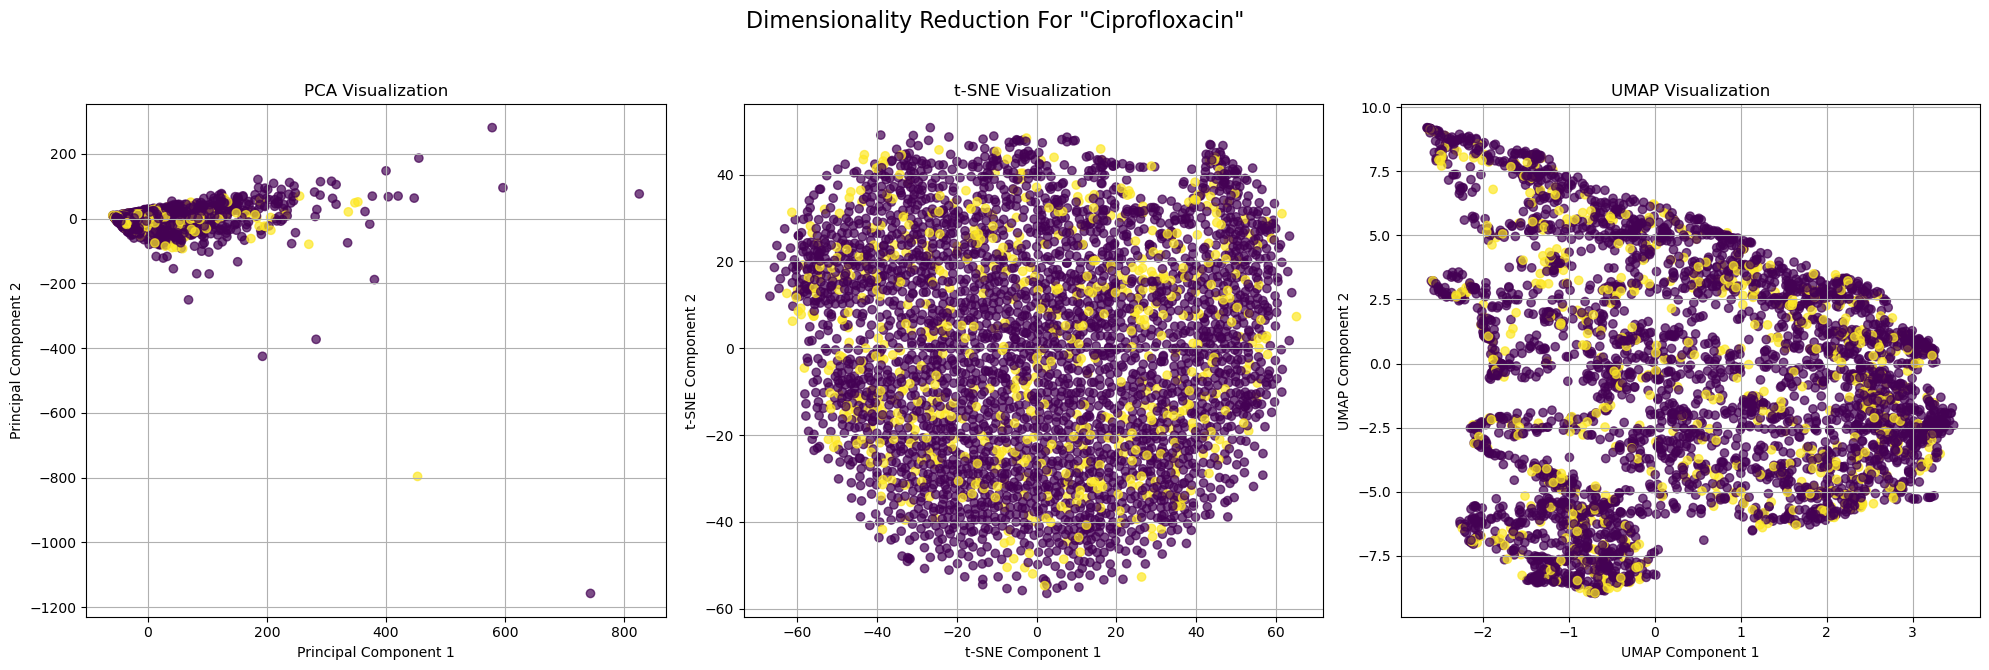

[2025-09-03 18:59:21.500] [CUML] [info] Building knn graph using brute force (configured from build_algo='auto')


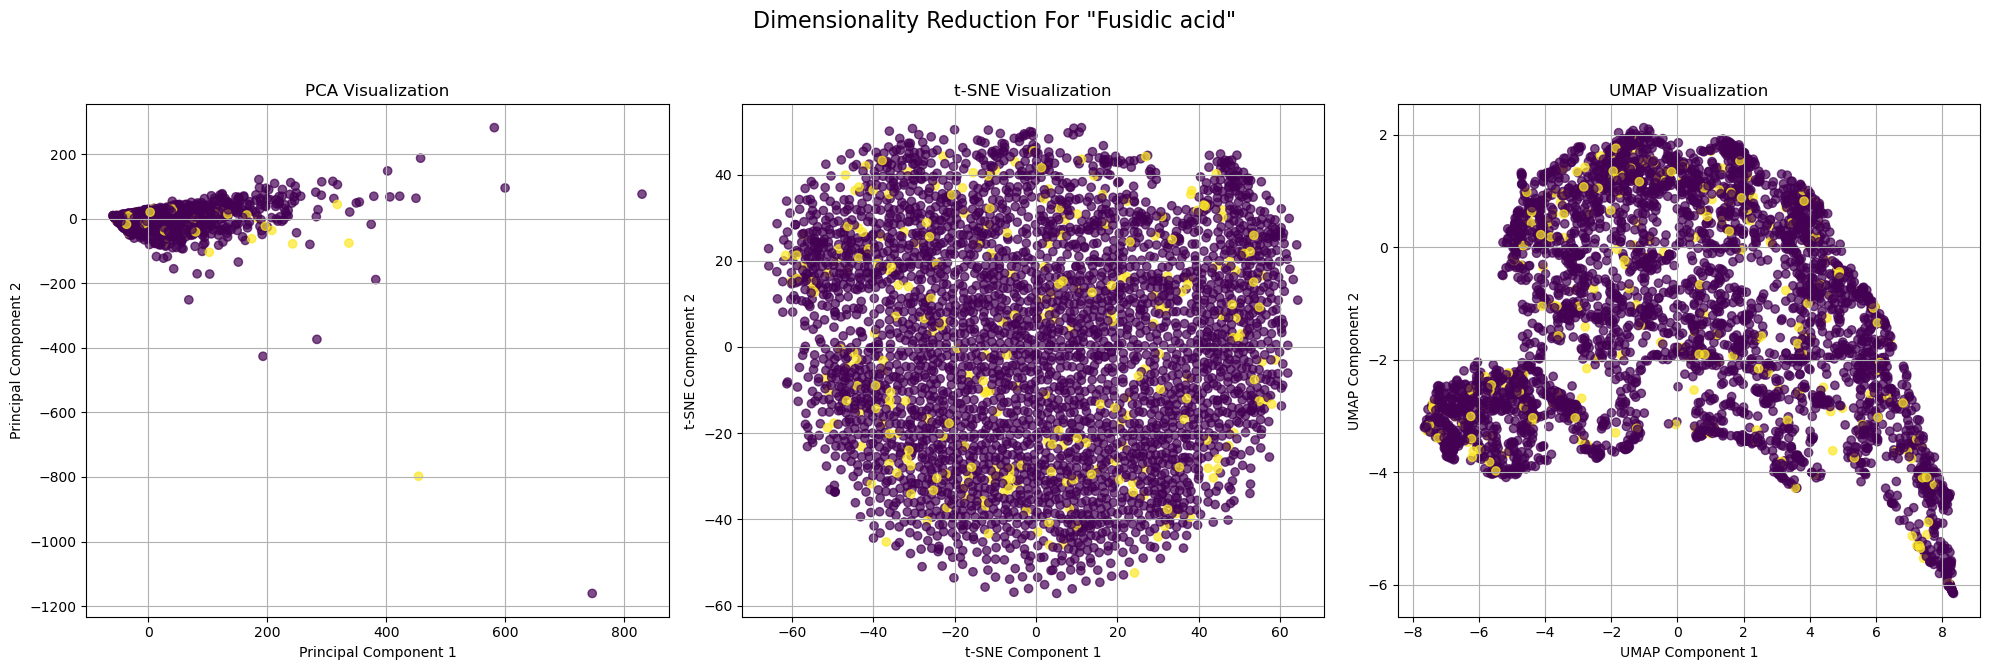

In [13]:
for antibiotic in antibiotics:
    antibiotic_df = df.iloc[:, :6000].join(df[antibiotic]).dropna()
    plot_dimensionality_reduction(antibiotic_df, title=f'Dimensionality Reduction For "{antibiotic}"')

### Features Importance

In [14]:
def plot_topn_feature_importance_mi(mi_series, title, n_top_features=50):

    top_features = mi_series.head(n_top_features)
    
    # Create the plot
    plt.figure(figsize=(14, 6))
    top_features.plot(kind='bar', color='skyblue')
    
    plt.title(f'Mutual Information of Top Features for "{title}"', fontsize=16)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Mutual Information Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_MI_over_squence(s, title):
    plt.figure(figsize=(14, 6))
    plt.plot(s.index, s.values, color="steelblue", linewidth=1)

    s_smooth = s.rolling(window=50, center=True).mean()
    plt.plot(s.index, s_smooth, color="red", linewidth=2, label="Smoothed trend (window=50)")

    plt.xlabel("Sequence Position")
    plt.ylabel(f'Mutual Information (MI) for "{title}"')
    plt.title("Mutual Information Trend Over Sequence")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

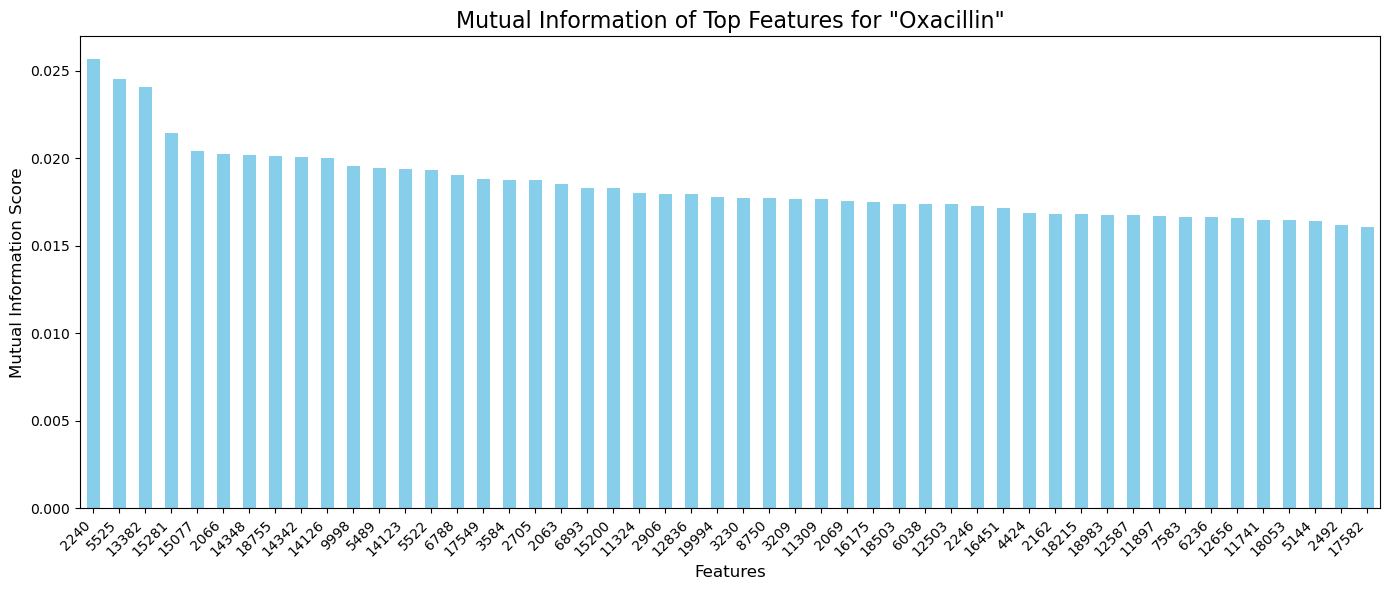

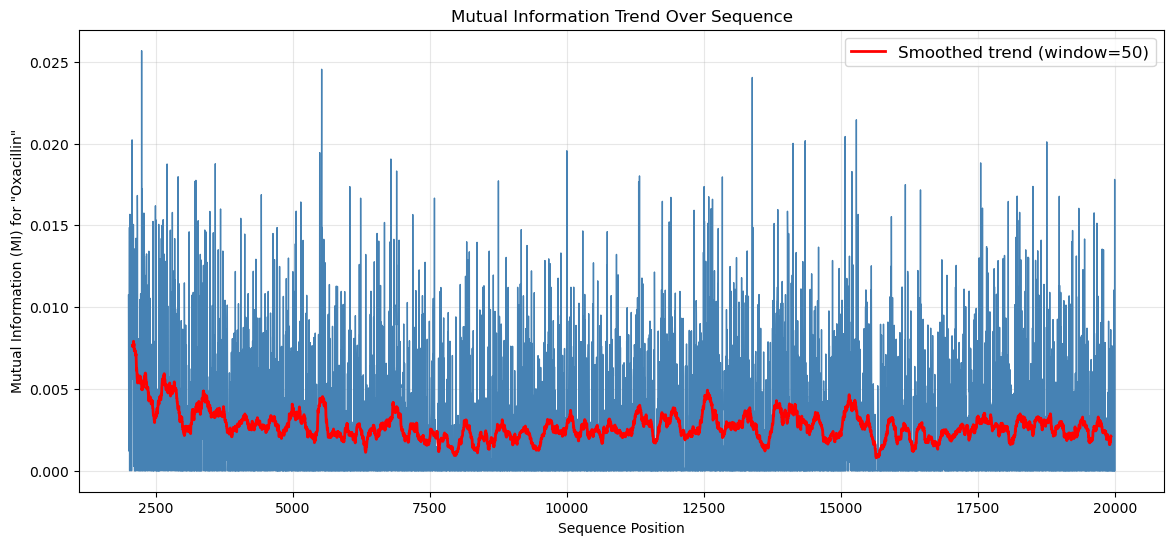

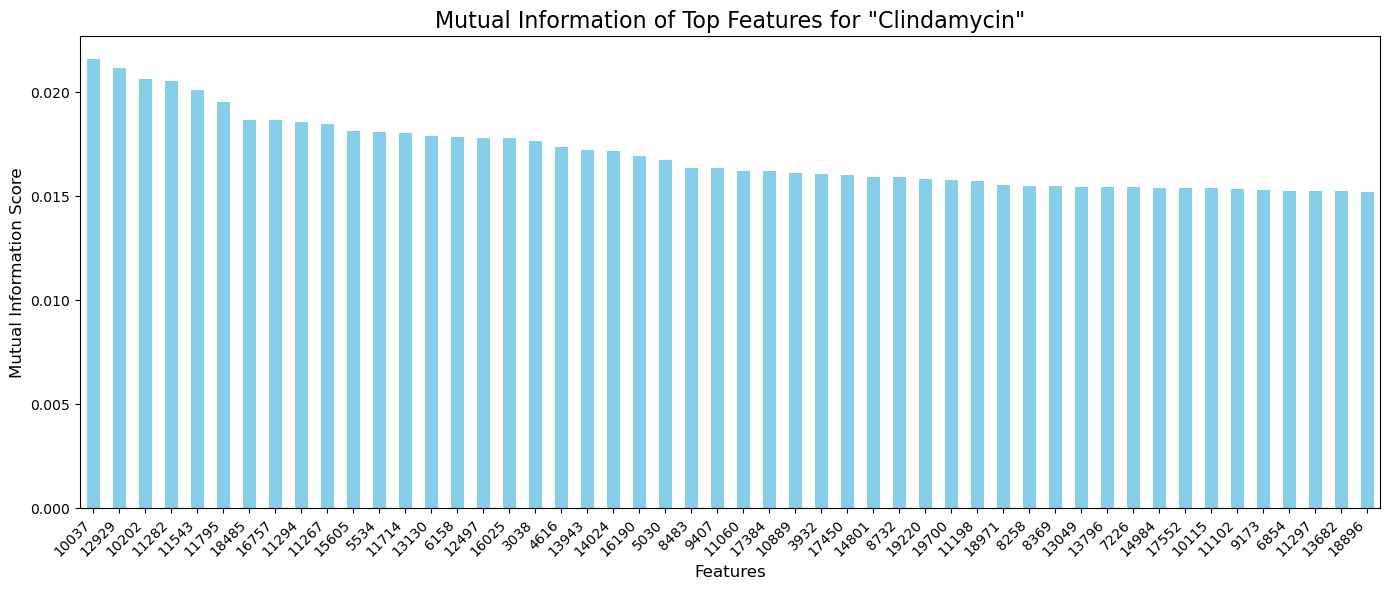

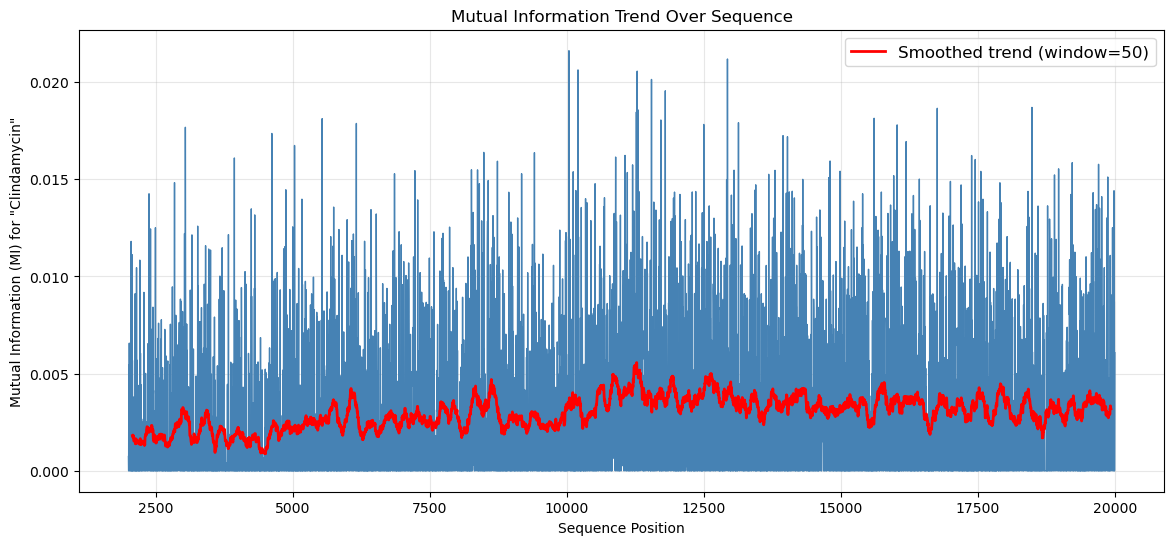

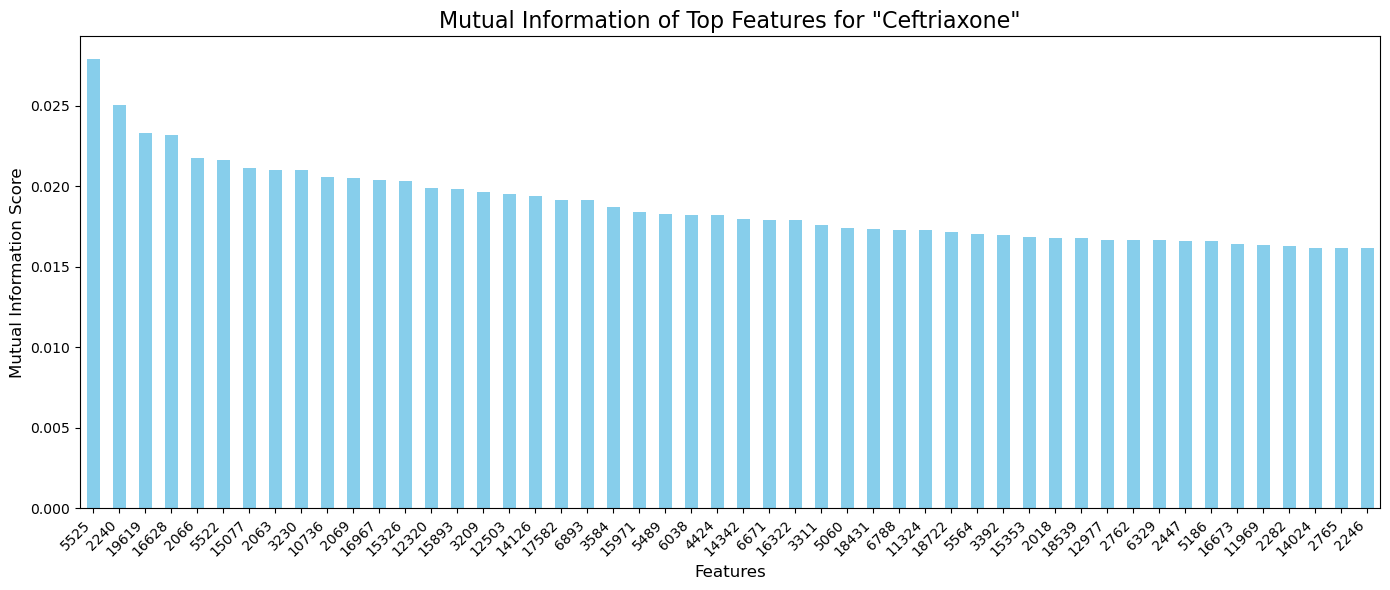

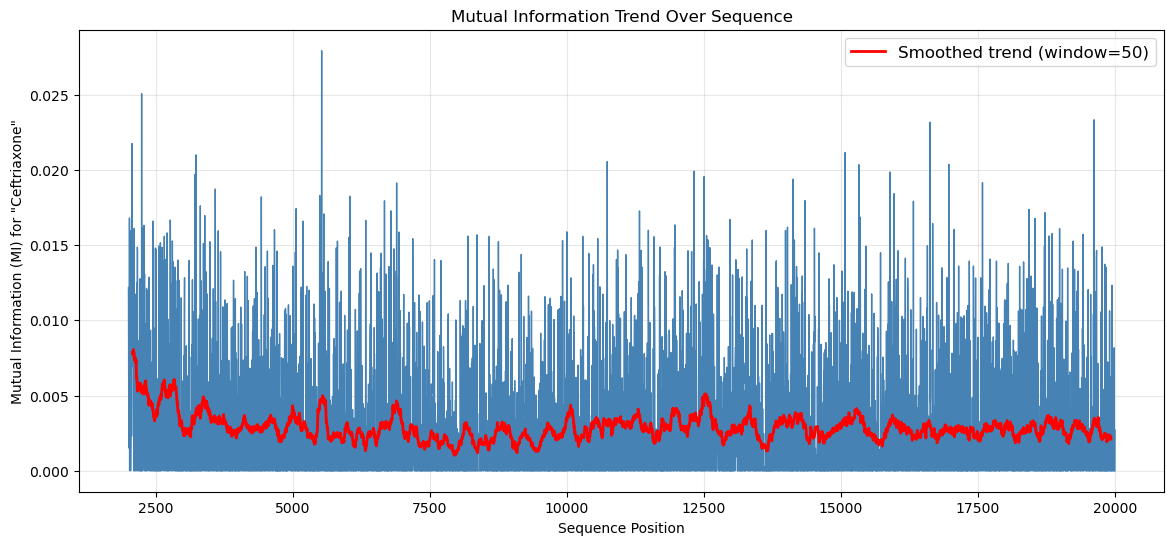

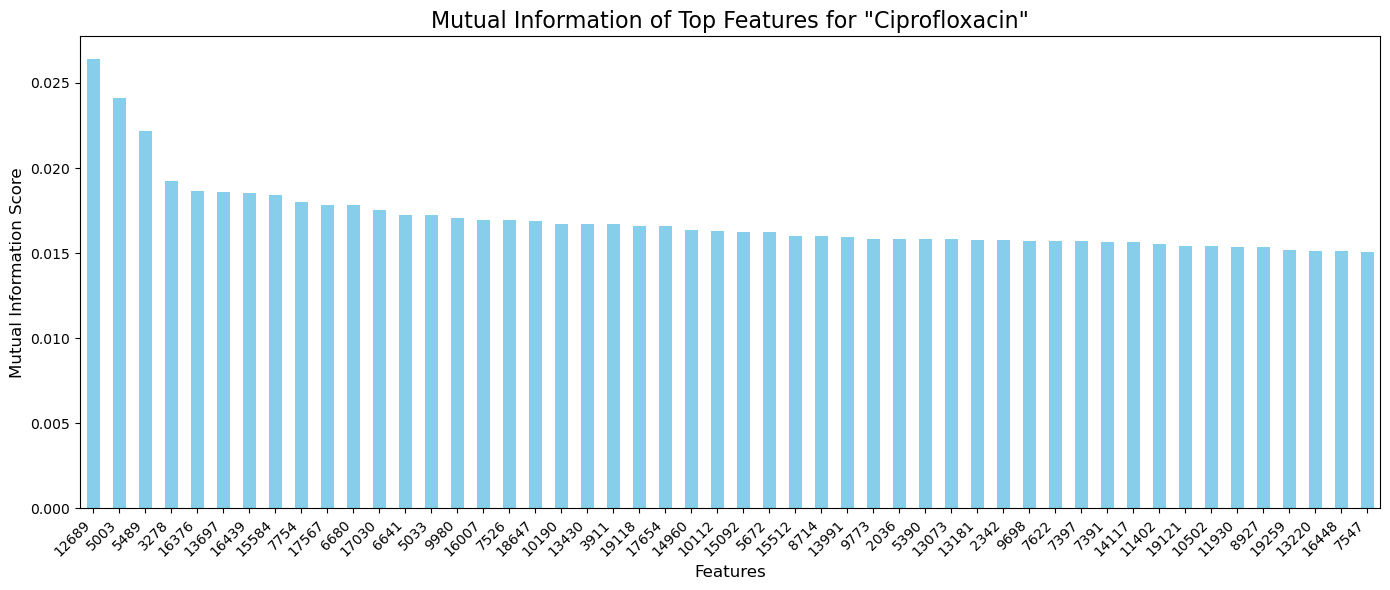

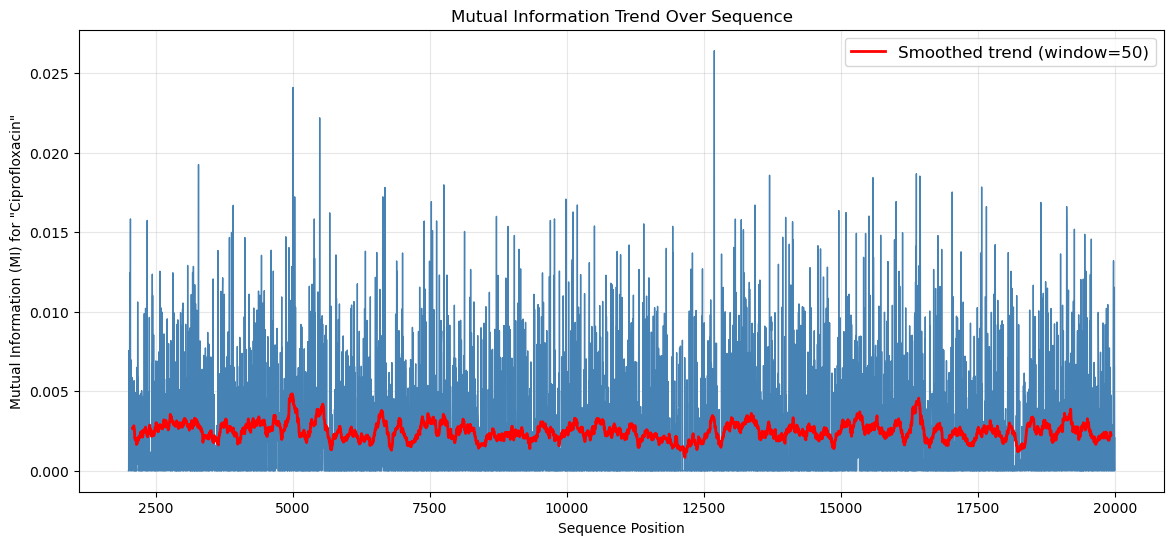

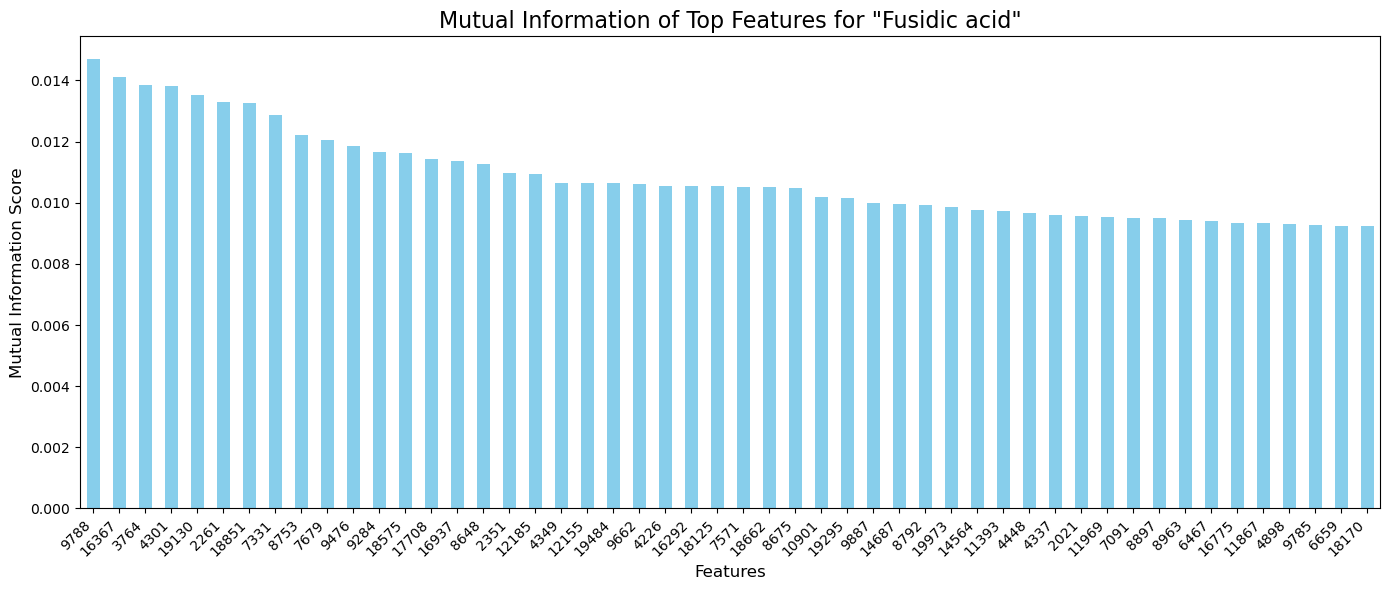

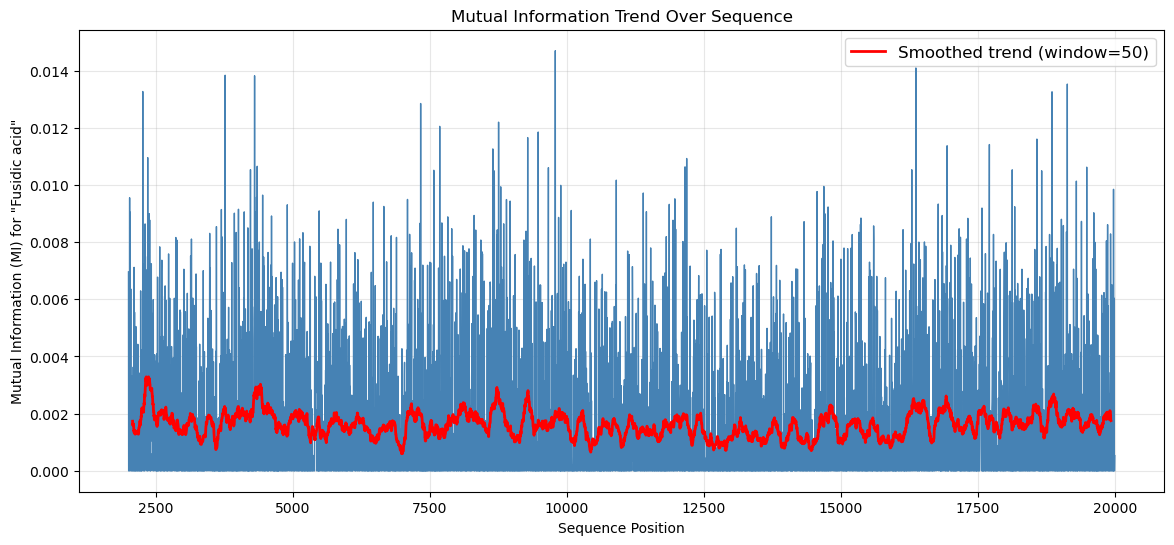

In [15]:
n_features = 6000

for antibiotic in antibiotics:
    antibiotic_df = df.iloc[:, :n_features].join(df[antibiotic]).dropna()
    X = antibiotic_df.iloc[:, :n_features]
    y = antibiotic_df.iloc[:, n_features]

    mi_scores = mutual_info_classif(X, y, random_state=42)
    mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    plot_topn_feature_importance_mi(mi_series, antibiotic)

    mi_series.index = mi_series.index.astype(int)
    mi_series = mi_series.sort_index()
    plot_MI_over_squence(mi_series, antibiotic)
    